## Introduction 

Vaccines have long been a cornerstone of public health, shielding individuals and entire communities from a wide array of infectious diseases. Among these, the ongoing efforts to immunize against seasonal influenza stand out as a vital and complex undertaking. Unlike specific pandemic strains such as the 2009 H1N1 "swine flu," seasonal flu is a persistent and annually recurring challenge, necessitating vigilance and adaptation by medical professionals every year. Seasonal influenza vaccines are developed and distributed on an annual basis to combat the most common flu strains predicted to circulate during the upcoming flu season. Scientists and researchers analyze global flu trends, collecting samples and data to determine which strains are most likely to pose a threat. The composition of the seasonal flu vaccine is then tailored each year based on these predictions, making it a unique and dynamic tool in the fight against influenza.

In the United States, a coordinated effort involving the government, healthcare providers, public health organizations, and even private companies is launched each year to promote and provide seasonal flu vaccines. This expansive campaign includes public education, accessibility initiatives, and collaboration with healthcare professionals to ensure that vaccines reach as many people as possible. Guiding these efforts are robust data collection and analysis, including surveys and studies that closely monitor vaccination rates. One such resource is the National Seasonal Flu Survey, a comprehensive effort to gather information about individuals' vaccination status, as well as insights into their lives, opinions, and behaviors related to vaccination. In this analysis, we will delve into the data from this survey, applying statistical and analytical techniques to uncover patterns and trends in seasonal flu vaccination. By understanding the factors that influence people's decisions to get vaccinated, such as age, location, education, and beliefs about vaccines, we can craft targeted strategies to increase vaccination rates.

## The Data

The dataset utilized in this project originates from the National 2009 H1N1 Flu Survey (NHFS), conducted during the 2009-10 flu season. This telephone survey was designed to monitor influenza immunization coverage in the United States, specifically targeting individuals aged 6 months or older. A collaboration between the National Center for Immunization and Respiratory Diseases (NCIRD) and the National Center for Health Statistics (NCHS) under the Centers for Disease Control and Prevention (CDC), the NHFS collected information from October 2009 to June 2010. Its primary focus was to produce timely estimates of vaccination coverage rates for both the monovalent pH1N1 and trivalent seasonal influenza vaccines during the 2009-2010 flu season in response to the H1N1 pandemic. The CDC continues to monitor seasonal flu vaccination through other ongoing annual phone surveys, but the NHFS stands as a one-time survey created for this specific purpose.

For our exploration we're given three CSV's:
1. **Training Labels**: This one holds the binary labels we'll be training our model(s) to predict. There are two target labels, `'h1n1_vaccine'` and '`seasonal_vaccine'`— for this analysis we're only concerned with the latter. A $0$ indicates that the given respondent did not receive the respective vaccine while a $1$ indicates that the given respondent received the respective vaccine. This file shares the `'respondent_id'` column with the Training Features CSV.

2. **Training Features**: These are the features we'll be using to predict the probability of a respondent receiving a vaccine. There are 35 features and each is a response to a survey question. Features comprise various topics, such as behavioral (whether a respondent touches their face, washes their hand, etc.), opinion (whether the respondent believed the h1n1 vaccine was effective, etc.), and demographic.

3. **Testing Features**: These features relate to the respondents for whom we will be predicting the likelihood of receiving the vaccine.

Let's go ahead and import the necessary imports and load in our data so that we can start cleaning it.

## Exploratory Data Analysis

### Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.edgecolor'] = 'black'

In [2]:
# Load in data
train_features = pd.read_csv('data/training_set_features.csv')
train_labels = pd.read_csv('data/training_set_labels.csv')

train_df = pd.merge(train_labels, train_features, on='respondent_id')
train_df.set_index('respondent_id', inplace=True)

In [3]:
# Examine the dataset's shape
print(f'train_df.shape: {train_df.shape}')

train_df.shape: (26707, 37)


In [4]:
# Examine the dataset's datatypes
train_df.dtypes

h1n1_vaccine                     int64
seasonal_vaccine                 int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                     

### Choosing our target

In [5]:
# Examine the vaccination value counts
for vaccine in ['seasonal_vaccine', 'h1n1_vaccine']:
    print(train_df[vaccine].value_counts())

# Given that seasonal vaccine has a better class balance, we'll choose that as our target

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


### Handling Nulls

In [6]:
train_df.isnull().sum()

h1n1_vaccine                       0
seasonal_vaccine                   0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
i

In [7]:
missing_data = train_df.isnull().sum()
missing_data_pct = missing_data / len(train_df)
missing_data_pct[missing_data_pct > .3]

health_insurance         0.459580
employment_industry      0.499120
employment_occupation    0.504362
dtype: float64

In [8]:
train_df['health_insurance'].fillna(0, inplace=True)
train_df.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)
train_df.shape

(26707, 35)

### Reconciling Datatypes

In [9]:
string_representations = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
string_representations

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

In [10]:
train_df_encoded = pd.get_dummies(train_df, columns=string_representations)
encoded_columns = [col for col in train_df_encoded.columns if any(col.startswith(str_col) for str_col in string_representations)]
train_df_encoded[encoded_columns].dtypes

age_group_18 - 34 Years                     uint8
age_group_35 - 44 Years                     uint8
age_group_45 - 54 Years                     uint8
age_group_55 - 64 Years                     uint8
age_group_65+ Years                         uint8
education_12 Years                          uint8
education_< 12 Years                        uint8
education_College Graduate                  uint8
education_Some College                      uint8
race_Black                                  uint8
race_Hispanic                               uint8
race_Other or Multiple                      uint8
race_White                                  uint8
sex_Female                                  uint8
sex_Male                                    uint8
income_poverty_<= $75,000, Above Poverty    uint8
income_poverty_> $75,000                    uint8
income_poverty_Below Poverty                uint8
marital_status_Married                      uint8
marital_status_Not Married                  uint8


In [11]:
train_df_encoded.shape

(26707, 63)

### Examining Feature Correlations

In [12]:
corr_mat = train_df_encoded.corr()
corr_mat[corr_mat == 1] = np.nan
five_most_correlated = corr_mat.unstack().sort_values(
    ascending=False
).drop_duplicates()[:5]

print(five_most_correlated)

doctor_recc_seasonal         doctor_recc_h1n1                        0.591868
behavioral_large_gatherings  behavioral_outside_home                 0.584085
opinion_h1n1_risk            opinion_seas_risk                       0.564208
age_group_65+ Years          employment_status_Not in Labor Force    0.498880
opinion_seas_sick_from_vacc  opinion_h1n1_sick_from_vacc             0.491546
dtype: float64


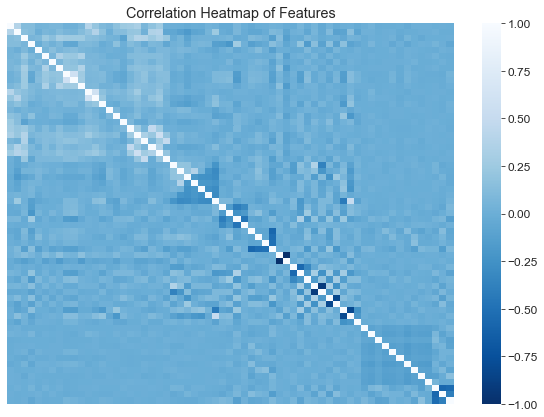

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(train_df_encoded.corr(), cmap='Blues_r')
plt.title('Correlation Heatmap of Features')
plt.xticks([])
plt.yticks([]);

## Preparing for Model Building

In [14]:
from sklearn.model_selection import train_test_split

target = 'seasonal_vaccine' # We want to predict seasonal vaccine

# We choose behavioral features + doctor recommendations for the vaccines as our features.
chosen_features = [column for column in train_df if "behavioral" in column] + \
                  ['doctor_recc_h1n1' ,'doctor_recc_seasonal']

X = train_df_encoded[chosen_features]
y = train_df_encoded[target]

seed = 42 # For reproducability
test_size = .2 # 20% of our data will be in the testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21365, 9), (5342, 9), (21365,), (5342,))

In [15]:
from sklearn.impute import SimpleImputer

def simple_impute(*Xs):
    results = []
    imputer = SimpleImputer(strategy='most_frequent')
    for X in Xs:
        X_imputed = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
        results.append(X_imputed)
    return tuple(results)

In [16]:
X_train, X_test = simple_impute(X_train, X_test)

print(f'Null values in X_train: {X_train.isnull().sum().sum()}')
print(f'Null values in X_test: {X_test.isnull().sum().sum()}')

Null values in X_train: 0
Null values in X_test: 0


In [17]:
print(f'Null values in y_train: {y_train.isnull().sum().sum()}')
print(f'Null values in y_test: {y_test.isnull().sum().sum()}')

Null values in y_train: 0
Null values in y_test: 0


## Building Models

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from model_iteration import ModelIteration

iterations = ModelIteration()

### Dummy Model: Dummy Model

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.0,0.0,0.0,0.0,0.5,0.5


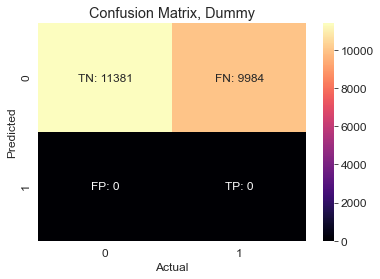

In [19]:
model_0 = 'Dummy'
dummy_model = make_pipeline(StandardScaler(), DummyClassifier(strategy='most_frequent', random_state=seed))
iterations.run_cv(model_0, dummy_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(dummy_model, model_0, X_train, y_train)

### Model 1: Simple Model (Logistic Regression)

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489


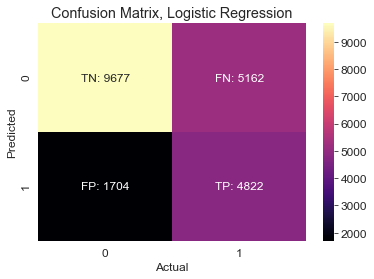

In [20]:
model_1 = 'Logistic Regression'
simple_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=seed))
iterations.run_cv(model_1, simple_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(simple_model, model_1, X_train, y_train)

### Model 2: Tuned Logistic Regression

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625


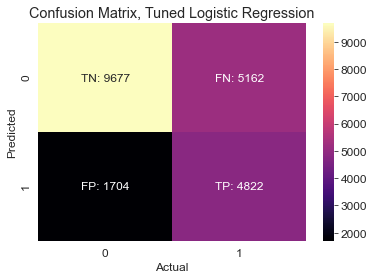

In [21]:
param_grid_1 = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

tuned_simple_model, tuned_simple_model_params = iterations.tune(
    simple_model, param_grid_1, X_train, y_train
)

model_2 = 'Tuned Logistic Regression'
iterations.run_cv(model_2, tuned_simple_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(tuned_simple_model, model_2, X_train, y_train)

In [22]:
print(tuned_simple_model_params)

{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


### Model 3: Decision Tree

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736


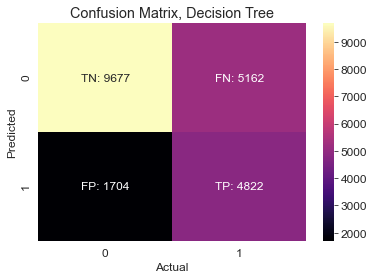

In [23]:
from sklearn.tree import DecisionTreeClassifier

model_3 = 'Decision Tree'
tree_model = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=seed))
iterations.run_cv(model_3, tree_model, X_train, y_train)
iterations.get_stats()
iterations.confusion(simple_model, model_3, X_train, y_train)

### Model 4: Tuned Decision Tree

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.493990,0.495092,0.588975,0.590767,0.695246,0.708621


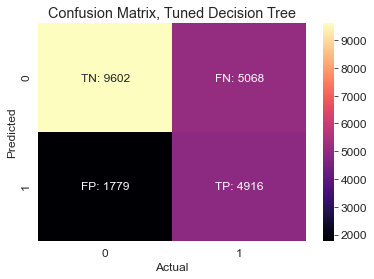

In [24]:
param_grid_2 = {
    'decisiontreeclassifier__max_depth': [None] + list(range(1, 101)),
    'decisiontreeclassifier__min_samples_split': range(2, 101),
    'decisiontreeclassifier__min_samples_leaf': range(1, 101),
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

tuned_tree_model, tuned_tree_model_params = iterations.tune(
    tree_model, param_grid_2, X_train, y_train, random_state=seed, method='random'
)

model_4 = 'Tuned Decision Tree'
iterations.run_cv(model_4, tuned_tree_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(tuned_tree_model, model_4, X_train, y_train)

In [25]:
print(tuned_tree_model_params)

{'decisiontreeclassifier__min_samples_split': 83, 'decisiontreeclassifier__min_samples_leaf': 14, 'decisiontreeclassifier__max_depth': 11, 'decisiontreeclassifier__criterion': 'gini'}


### Model 5: Random Forest

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.493990,0.495092,0.588975,0.590767,0.695246,0.708621
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471


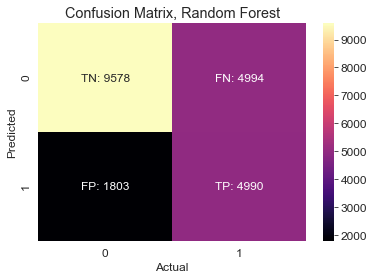

In [26]:
from sklearn.ensemble import RandomForestClassifier

model_5 = 'Random Forest'
forest_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=seed))
iterations.run_cv(model_5, forest_model, X_train, y_train)
iterations.get_stats()
iterations.confusion(forest_model, model_5, X_train, y_train)

### Model 6: Tuned Random Forest

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.493990,0.495092,0.588975,0.590767,0.695246,0.708621
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Random Forest,0.493389,0.496494,0.588216,0.592197,0.694274,0.711674


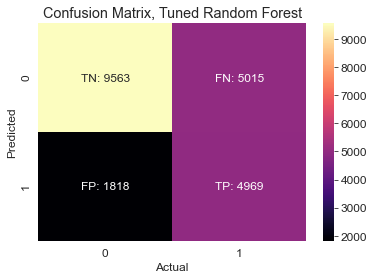

In [27]:
param_grid_3 = {
    'randomforestclassifier__n_estimators': range(50, 200),
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__max_depth': [None] + list(range(5, 50)),
    'randomforestclassifier__min_samples_split': range(2, 20),
    'randomforestclassifier__min_samples_leaf': range(1, 20),
    'randomforestclassifier__bootstrap': [True, False]
}


tuned_forest_model, tuned_forest_model_params = iterations.tune(
    forest_model, param_grid_3, X_train, y_train, random_state=seed, method='random'
)

model_6 = 'Tuned Random Forest'
iterations.run_cv(model_6, tuned_forest_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(tuned_forest_model, model_6, X_train, y_train)

In [28]:
print(tuned_forest_model_params)

{'randomforestclassifier__n_estimators': 138, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__bootstrap': False}


### Model 7: Tuned Random Forest (New Features)

In [29]:
new_features = chosen_features.copy()

new_features += [
    col for col in train_df_encoded.columns \
        if 'opinion' in col \
        or 'education' in col \
        or 'age' in col \
        or col == 'health_insurance'
]

len(new_features)

25

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.493990,0.495092,0.588975,0.590767,0.695246,0.708621
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Random Forest,0.493389,0.496494,0.588216,0.592197,0.694274,0.711674
Random Forest (New Features),0.738582,0.828450,0.746889,0.837923,0.843657,0.936893


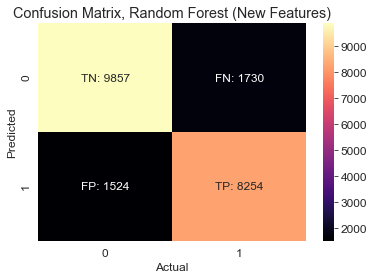

In [30]:
model_7 = 'Random Forest (New Features)'
X_nf = train_df_encoded[new_features].copy()

X_train_nf, X_test_nf, _, _ = train_test_split(X_nf, y, random_state=seed, test_size=test_size)
X_train_nf, X_test_nf = simple_impute(X_train_nf, X_test_nf)

iterations.run_cv(model_7, tuned_forest_model, X_train_nf, y_train)

iterations.get_stats()
iterations.confusion(tuned_forest_model, model_7, X_train_nf, y_train)

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Dummy,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.493990,0.495092,0.588975,0.590767,0.695246,0.708621
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Random Forest,0.493389,0.496494,0.588216,0.592197,0.694274,0.711674
Random Forest (New Features),0.738582,0.828450,0.746889,0.837923,0.843657,0.936893
Tuned Random Forest (New Features),0.741586,0.778721,0.750863,0.788842,0.847036,0.889214


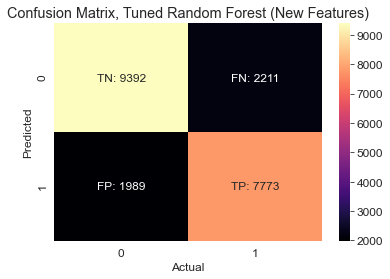

In [31]:
tuned_forest_model_nf, tuned_forest_model_nf_params = iterations.tune(
    tuned_forest_model, param_grid_3, X_train_nf, y_train, random_state=seed, method='random'
)

model_8 = 'Tuned Random Forest (New Features)'
iterations.run_cv(model_8, tuned_forest_model_nf, X_train_nf, y_train)

iterations.get_stats()
iterations.confusion(tuned_forest_model_nf, model_8, X_train_nf, y_train)

## Analysis with the Best Model

### Determining the Best Model

In [32]:
best_model = tuned_forest_model_nf
print(best_model[1])

RandomForestClassifier(max_depth=21, min_samples_leaf=9, min_samples_split=9,
                       n_estimators=91, random_state=42)


In [33]:
from sklearn.metrics import recall_score, accuracy_score

y_pred = best_model.predict(X_test_nf)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy Score on Test Data: {accuracy:,.4f}')
print(f'Recall Score on Test Data: {recall:,.4f}')

Accuracy Score on Test Data: 0.7784
Recall Score on Test Data: 0.7552


### Feature Importances

In [34]:
feature_importances = tuned_forest_model_nf.steps[1][1].feature_importances_
feature_importances_df = pd.DataFrame(feature_importances, index=X_train_nf.columns)
feature_importances_df = feature_importances_df.rename(
    columns={0: 'Feature Importance'}
).sort_values(by='Feature Importance', ascending=False
)

top_10 = feature_importances_df[:10]
top_5 = feature_importances_df[:5]

In [89]:
top_10.index = [
    'Believes Seasonal Vaccine is Effective',
    'Believes Seasonal Flu is Risky',
    'Received Doctor\'s Recommendation for Seasonal Vaccine',
    '65+ Years Old',
    'Believes H1N1 is Risky',
    'Believes H1N1 Vaccine is Effective',
    'Believes They Get Sick from Seasonal Vaccine',
    '18-34 Years Old',
    'Received Doctor\'s Recommendation for H1N1 Vaccine',
    'Has Health Insurance'
]

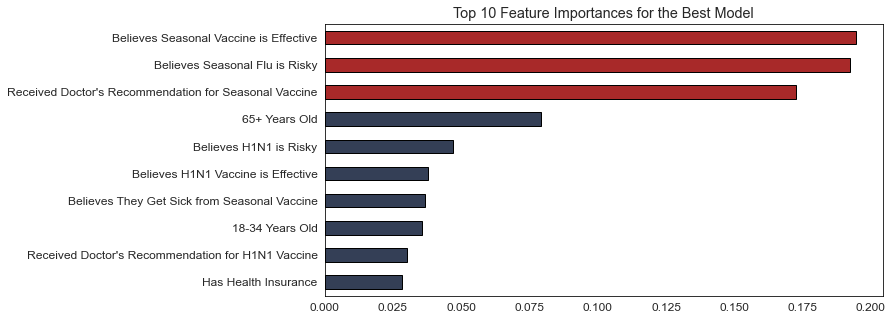

In [153]:
ax = top_10.iloc[::-1].plot.barh(figsize=(10,5), color='#A82929', legend=False, edgecolor='k')

for i in range(7):
    ax.get_children()[i].set_color('#343f56')
    ax.get_children()[i].set_edgecolor('k')

plt.grid(False)
plt.title('Top 10 Feature Importances for the Best Model');

### Addressing Opinions on the Seasonal Flu and the Vaccine

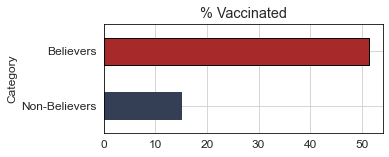

In [165]:
# Likelihood of getting the vaccine based on belief

# Define believers and non-believers based on opinion_seas_vacc_effective values
believers = [3, 4, 5]
non_believers = [1, 2]

# Define vaccinated individuals
vacc = train_df_encoded.seasonal_vaccine == 1
# Define believers and non-believers
believe = train_df_encoded.opinion_seas_vacc_effective.isin(believers)
does_not_believe = train_df_encoded.opinion_seas_vacc_effective.isin(non_believers)

# Number of vaccinated individuals who believe in vaccine effectiveness
num_vacc_and_believe = len(train_df_encoded[vacc & believe])
# Total number of individuals who believe in vaccine effectiveness
num_believe = len(train_df_encoded[believe])
# Percentage of believers who got vaccinated
pct_vacc_and_believe = num_vacc_and_believe / num_believe

# Number of vaccinated individuals who do not believe in vaccine effectiveness
num_vacc_and_not_believe = len(train_df_encoded[vacc & does_not_believe])
# Total number of individuals who do not believe in vaccine effectiveness
num_not_believe = len(train_df_encoded[does_not_believe])
# Percentage of non-believers who got vaccinated
pct_vacc_and_not_believe = num_vacc_and_not_believe / num_not_believe

opinion = {
    'Category': ['Believers', 'Non-Believers'],
    'Percentage Vaccinated': [pct_vacc_and_believe * 100, pct_vacc_and_not_believe * 100]
}

opinion = pd.DataFrame(opinion).set_index('Category')
ax2 = opinion.iloc[::-1].plot.barh(color='#A82929', edgecolor='k', legend=False, figsize=(5, 2))

for i in range(1):
    ax2.get_children()[i].set_color('#343f56')

plt.title('% Vaccinated');

In [ ]:
opinion.to_csv('data/vaccination_opinion.csv')

### The Necessity of Doctor Recommendations

In [143]:
# Likelihood of getting the vaccine given a recommendation from the doctor

# Define doctor's recommendation for seasonal vaccine and vaccination
has_doctors_rec = train_df_encoded.doctor_recc_seasonal == 1

# Number and percentage of vaccinated individuals with doctor's recommendation
num_vacc_and_has_rec = len(train_df_encoded[vacc & has_doctors_rec])
num_has_rec = len(train_df_encoded[has_doctors_rec])
pct_vacc_and_has_rec = num_vacc_and_has_rec / num_has_rec

# Number and percentage of vaccinated individuals without doctor's recommendation
num_vacc_and_no_rec = len(train_df_encoded[vacc & ~has_doctors_rec])
num_no_rec = len(train_df_encoded[~has_doctors_rec])
pct_vacc_and_no_rec = num_vacc_and_no_rec / num_no_rec

# Create a DataFrame with the data
rec = {
    'Category': ['Has Doctor\'s Recommendation', 'No Doctor\'s Recommendation'],
    'Percentage Vaccinated': [pct_vacc_and_has_rec * 100, pct_vacc_and_no_rec * 100]
}
rec = pd.DataFrame(rec).set_index('Category')
rec.to_csv('data/doctor_rec.csv')

In [169]:
# Likelihood of getting vaccinated if old vs. if young

old = train_df_encoded['age_group_65+ Years'] == 1
young = train_df_encoded['age_group_18 - 34 Years'] == 1

num_vacc_and_old = len(train_df_encoded[vacc & old])
num_old = len(train_df_encoded[old])
pct_vacc_and_old = num_vacc_and_old / num_old

num_vacc_and_young = len(train_df_encoded[vacc & young])
num_young = len(train_df_encoded[young])
pct_vacc_and_young = num_vacc_and_young / num_young

age = {
    'Category': ['Young (18-34 Y.O.)', 'Old (65+ Y.O.)'],
    'Percentage Vaccinated': [pct_vacc_and_young * 100, pct_vacc_and_old * 100]
}

age = pd.DataFrame(age).set_index('Category')
age.to_csv('data/age_differences.csv')

0.4656082674954132

In [175]:
vacc_pct = len(train_df_encoded[vacc]) / len(train_df_encoded)
vaccinated_pct = {
    'Category': ['Vaccinated', 'Not Vaccinated'],
    'Percentage': [vacc_pct*100, (1-vacc_pct)*100]
}

vaccinated = pd.DataFrame(vaccinated_pct).set_index('Category')
vaccinated.to_csv('data/pct_vaccinated.csv')

In [40]:
calculate_percentage(train_df_encoded, 'doctor_recc_seasonal')

0.30306661174972854

In [41]:
calculate_percentage(train_df_encoded, 'doctor_recc_h1n1')

0.20249372823604297

Text(0, 0.5, '')

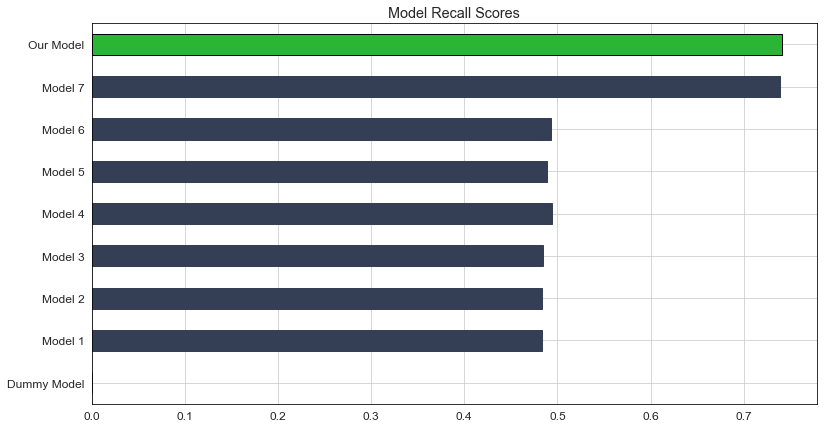

In [67]:
ax1 = iterations.stats.set_index('Model').T.rename(columns={
    'Dummy': 'Dummy Model',
    'Logistic Regression': 'Model 1',
    'Tuned Logistic Regression': 'Model 2',
    'Decision Tree': 'Model 3',
    'Tuned Decision Tree': 'Model 4',
    'Random Forest': 'Model 5',
    'Tuned Random Forest': 'Model 6',
    'Random Forest (New Features)': 'Model 7',
    'Tuned Random Forest (New Features)': 'Our Model'
}).T['Test Recall'].plot.barh(figsize=(13, 7), color='#2AB634', edgecolor='k')

for i in range(8):
    ax1.get_children()[i].set_color('#343f56')

plt.title('Model Recall Scores')
plt.ylabel('')

In [70]:
top_10

,Feature Importance
opinion_seas_vacc_effective,0.194574
opinion_seas_risk,0.192493
doctor_recc_seasonal,0.172515
age_group_65+ Years,0.079424
opinion_h1n1_risk,0.046963
opinion_h1n1_vacc_effective,0.037799
opinion_seas_sick_from_vacc,0.036713
age_group_18 - 34 Years,0.035600
doctor_recc_h1n1,0.030246
health_insurance,0.028215


In [76]:
len(train_df_encoded[(train_df_encoded['age_group_18 - 34 Years'] == 1) & (train_df_encoded['seasonal_vaccine'] == 1)]) / len(train_df_encoded[(train_df_encoded['age_group_18 - 34 Years'] == 1)])

0.28456375838926173